Number 1-- In this code I am processing my datasets.These datasets are currently raw data therefore I am processing them. My iphone apple health datasets. Their names are below so datasets split into columns such as value, time of the day and units. Also the rows represents the dates. So there are lots of periods of data in a day. As you can see the below image  my daily data includes periods of data which records my activities. So I needed to achieve the aggreagted daily values of my datasets. For step count and flights climbed datasets,I summed the values of daily periods and I got the daily summed values. For rest of the datasets I took the averages of every period of my activities and I got the the averages of daily period activites. Thus I can analyse the daily data more precisely. 



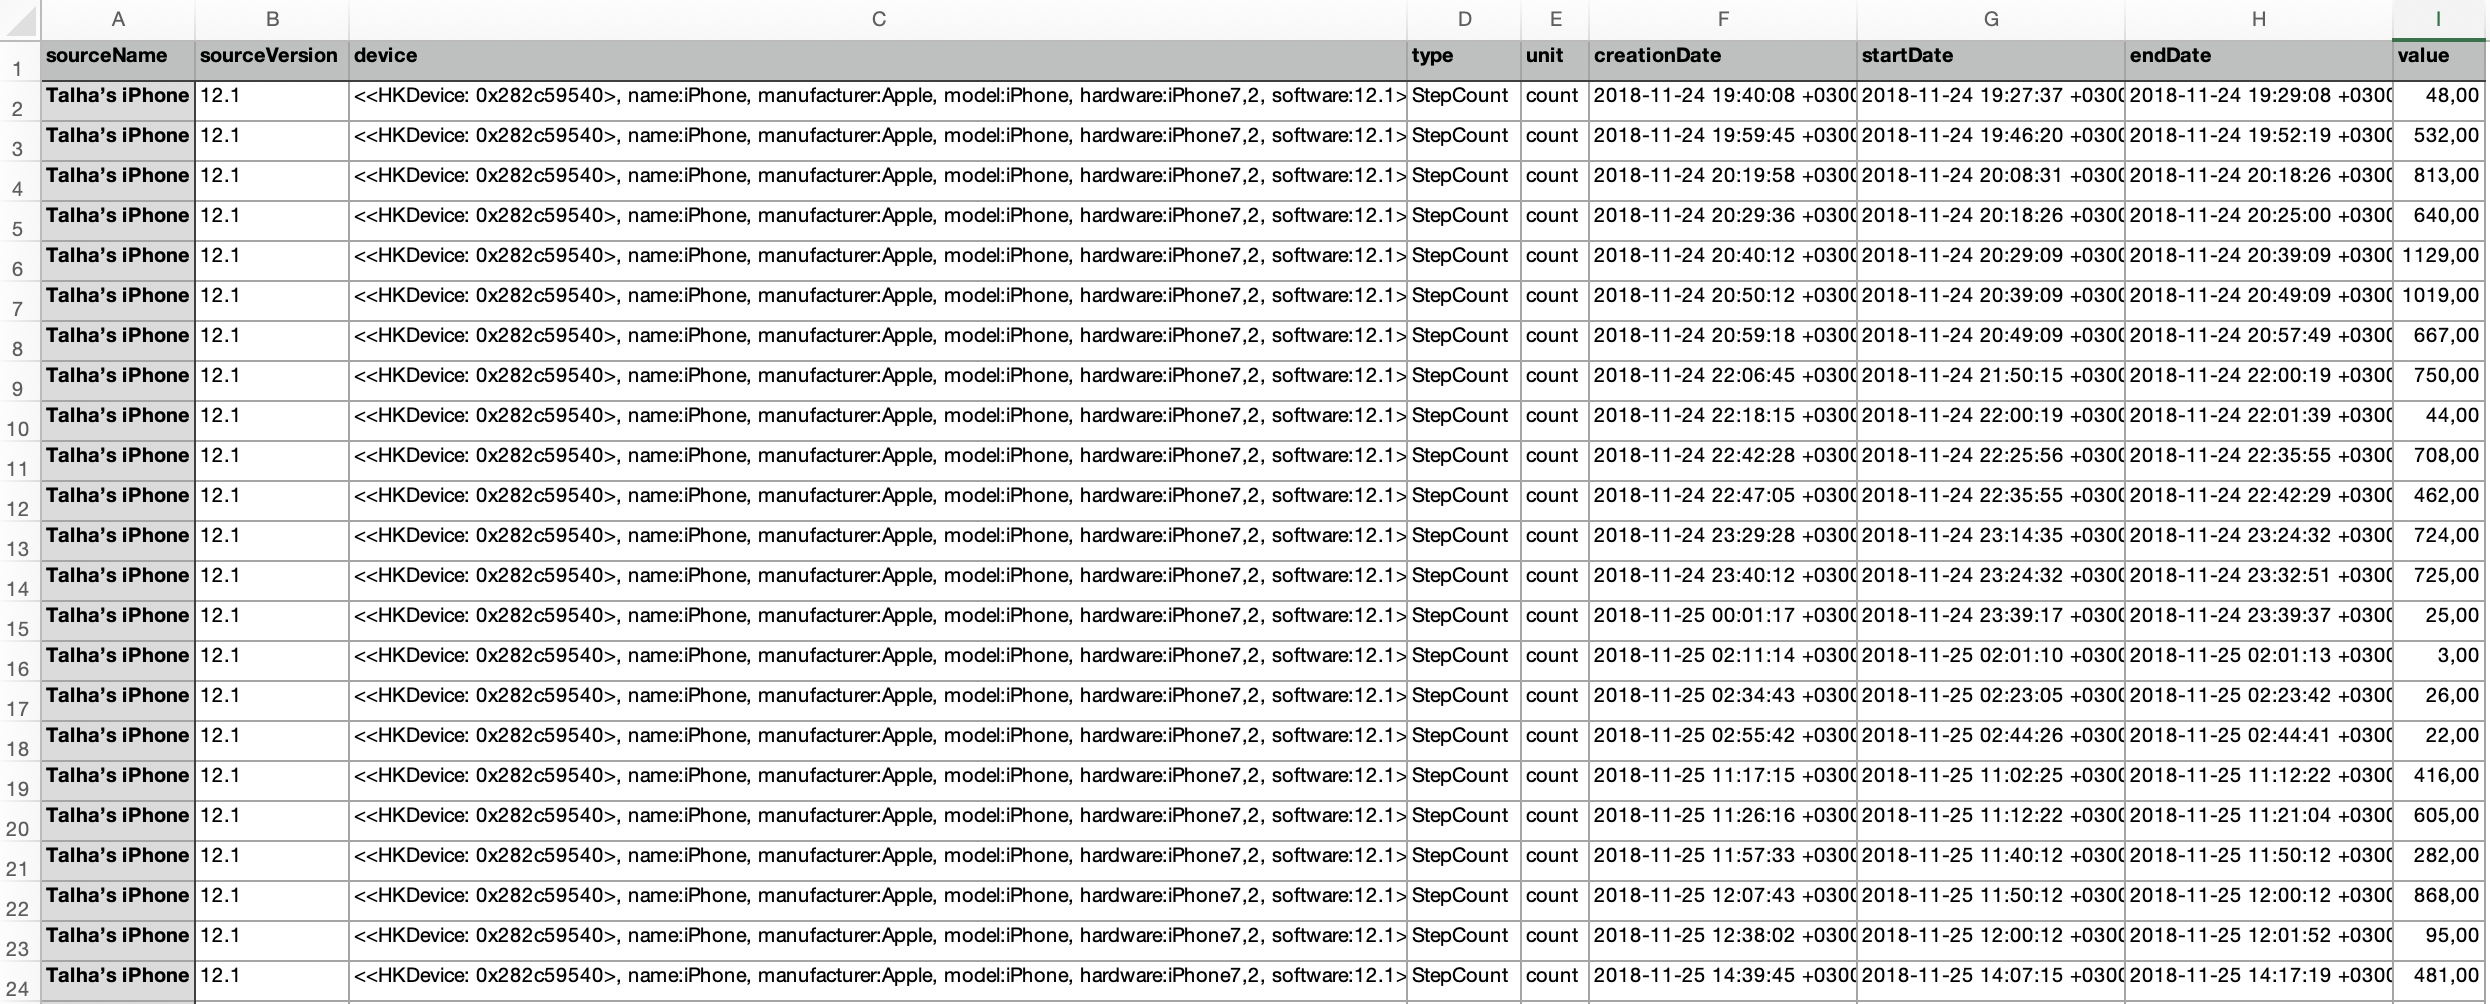

In [6]:

import pandas as pd

# List the datasets and their processing requirements
datasets_info = {
    "StepCount": {"operation": "sum", "file_name": "StepCount.xlsx"},
    "FlightsClimbed": {"operation": "sum", "file_name": "FlightsClimbed.xlsx"},
    "HeadphoneAudioExposure": {"operation": "mean", "file_name": "HeadphoneAudioExposure.xlsx"},
    "WalkingAsymmetryPercentage": {"operation": "mean", "file_name": "WalkingAsymmetryPercentage.xlsx"},
    "WalkingDoubleSupportPercentage": {"operation": "mean", "file_name": "WalkingDoubleSupportPercentage.xlsx"},
    "WalkingSpeed": {"operation": "mean", "file_name": "WalkingSpeed.xlsx"},
    "WalkingStepLength": {"operation": "mean", "file_name": "WalkingStepLength.xlsx"},
    
    
    

    # Add other datasets here
}


# Process each dataset
for dataset_name, info in datasets_info.items():
    try:
        # Load the dataset from an Excel file
        df = pd.read_excel(info['file_name'])

        # Print column names to verify the correct column is being used
        print(f"Columns in {dataset_name} file: {df.columns.tolist()}")

        # Ensure the 'startDate' column is correctly named and convert to datetime
        # Replace 'startDate' with the actual column name if different
        df['startDate'] = pd.to_datetime(df['startDate'])

        # Process the data based on the operation needed
        if info['operation'] == "sum":
            # Sum the values for each day
            processed_data = df.groupby(df['startDate'].dt.date)['value'].sum().reset_index()
        elif info['operation'] == "mean":
            # Average the values for each day
            processed_data = df.groupby(df['startDate'].dt.date)['value'].mean().reset_index()
        
        # Assuming 'device' and 'unit' are constant for each day
        processed_data['device'] = df.groupby(df['startDate'].dt.date)['device'].first().reset_index(drop=True)
        processed_data['unit'] = df.groupby(df['startDate'].dt.date)['unit'].first().reset_index(drop=True)

        # Save the processed data to a new Excel file
        processed_file_name = f"{dataset_name}_processed.xlsx"
        processed_data.to_excel(processed_file_name, index=False)

        print(f"Processed data for {dataset_name} saved to {processed_file_name}")
    except FileNotFoundError:
        print(f"File {info['file_name']} not found.")
    except Exception as e:
        print(f"An error occurred while processing {dataset_name}: {e}")


Columns in StepCount file: ['sourceName', 'sourceVersion', 'device', 'type', 'unit', 'creationDate', 'startDate', 'endDate', 'value']
Processed data for StepCount saved to StepCount_processed.xlsx
Columns in FlightsClimbed file: ['sourceName', 'sourceVersion', 'device', 'type', 'unit', 'creationDate', 'startDate', 'endDate', 'value']
Processed data for FlightsClimbed saved to FlightsClimbed_processed.xlsx
Columns in HeadphoneAudioExposure file: ['sourceName', 'sourceVersion', 'device', 'type', 'unit', 'creationDate', 'startDate', 'endDate', 'value']
Processed data for HeadphoneAudioExposure saved to HeadphoneAudioExposure_processed.xlsx
Columns in WalkingAsymmetryPercentage file: ['sourceName', 'sourceVersion', 'device', 'type', 'unit', 'creationDate', 'startDate', 'endDate', 'value']
Processed data for WalkingAsymmetryPercentage saved to WalkingAsymmetryPercentage_processed.xlsx
Columns in WalkingDoubleSupportPercentage file: ['sourceName', 'sourceVersion', 'device', 'type', 'unit', '

Number 2--- In this code I am filling the missing dates in my processed datasets. Firstly, there are missing dates which my phone did nor record the days at all so I am creating new rows for these dates. Then, fill the missing values with the mean of the value data of all days. For the other columns I filled the missing cells with the closest upper row such which device recorded this piece of data. Secondly, there are 0 values in my processed datasets, to analyze the dataset more accurately I changed their values with the mean of the non zero values which does not take the 0 values for the calculation of mean of the all days. 

In [11]:
import pandas as pd

# List of processed dataset file names
dataset_files = [
    "HeadphoneAudioExposure_processed.xlsx",
    "StepCount_processed.xlsx",
    "FlightsClimbed_processed.xlsx",
    "WalkingAsymmetryPercentage_processed.xlsx",
    "WalkingSpeed_processed.xlsx",
    "WalkingStepLength_processed.xlsx",
    "WalkingDoubleSupportPercentage_processed.xlsx"
]

# Process each dataset
for file_name in dataset_files:
    # Load the dataset
    df = pd.read_excel(file_name)

    # Set 'startDate' as the index and parse it as a datetime
    df['startDate'] = pd.to_datetime(df['startDate'])
    df.set_index('startDate', inplace=True)

    # Create a date range that covers all dates in the dataset
    date_range = pd.date_range(start=df.index.min(), end=df.index.max())

    # Reindex the dataframe to include all dates, filling missing dates with NaNs
    df_reindexed = df.reindex(date_range, fill_value=pd.NA)

    # Calculate the mean of the 'value' column excluding zeros and NaNs
    non_zero_mean = df_reindexed.loc[df_reindexed['value'].notna() & (df_reindexed['value'] != 0), 'value'].mean()

    # Impute zero values with the non-zero mean
    df_reindexed['value'] = df_reindexed['value'].replace(0, non_zero_mean)
    # Impute NaN values in the 'value' column with the non-zero mean
    df_reindexed['value'].fillna(non_zero_mean, inplace=True)

    # Forward fill the other columns to impute missing values with the information from the closest upper row
    df_reindexed.fillna(method='ffill', inplace=True)

    # If the first row is still NaN after forward fill (no upper row), back fill those values
    df_reindexed.fillna(method='bfill', inplace=True)

    # Reset the index to turn the dates back into a column
    df_reindexed.reset_index(inplace=True)
    df_reindexed.rename(columns={'index': 'startDate'}, inplace=True)

    # Define the output file name
    output_file_name = file_name.replace('.xlsx', '_imputed.xlsx')

    # Save the new DataFrame with imputed values to a new Excel file
    df_reindexed.to_excel(output_file_name, index=False)

    print(f"Imputed and saved {file_name} data to {output_file_name}")



Imputed and saved HeadphoneAudioExposure_processed.xlsx data to HeadphoneAudioExposure_processed_imputed.xlsx
Imputed and saved StepCount_processed.xlsx data to StepCount_processed_imputed.xlsx
Imputed and saved FlightsClimbed_processed.xlsx data to FlightsClimbed_processed_imputed.xlsx
Imputed and saved WalkingAsymmetryPercentage_processed.xlsx data to WalkingAsymmetryPercentage_processed_imputed.xlsx
Imputed and saved WalkingSpeed_processed.xlsx data to WalkingSpeed_processed_imputed.xlsx
Imputed and saved WalkingStepLength_processed.xlsx data to WalkingStepLength_processed_imputed.xlsx
Imputed and saved WalkingDoubleSupportPercentage_processed.xlsx data to WalkingDoubleSupportPercentage_processed_imputed.xlsx


Number 3 --- In this code, we can see the weekly avergaes of all dataset across for all years to see the changes basically. So we can observe that at the period of pandemy's first peak season we have been lock down. Therefore we can see the change of it on the stepcount and flightclimbed graph visually.  

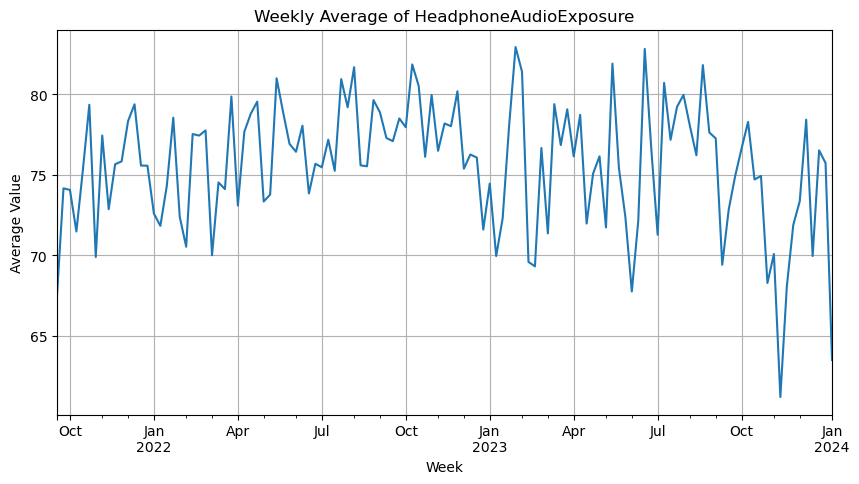

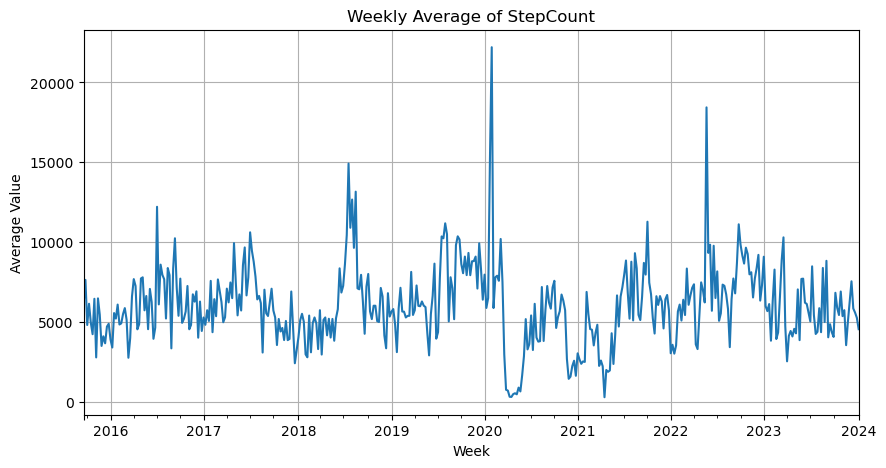

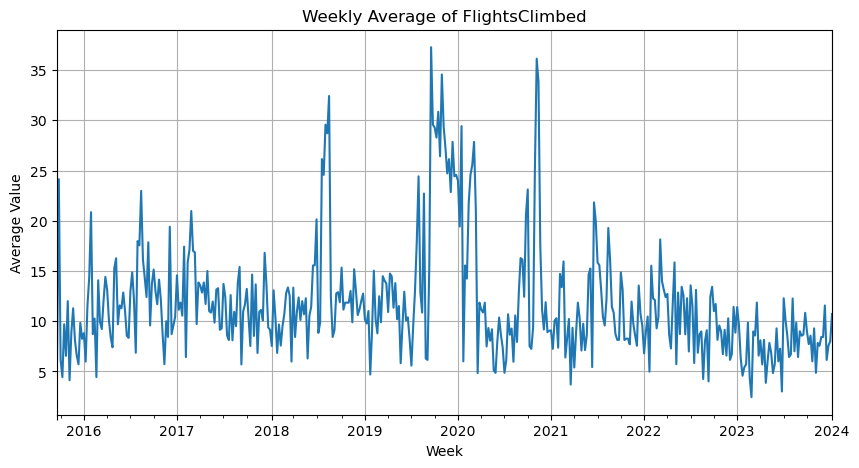

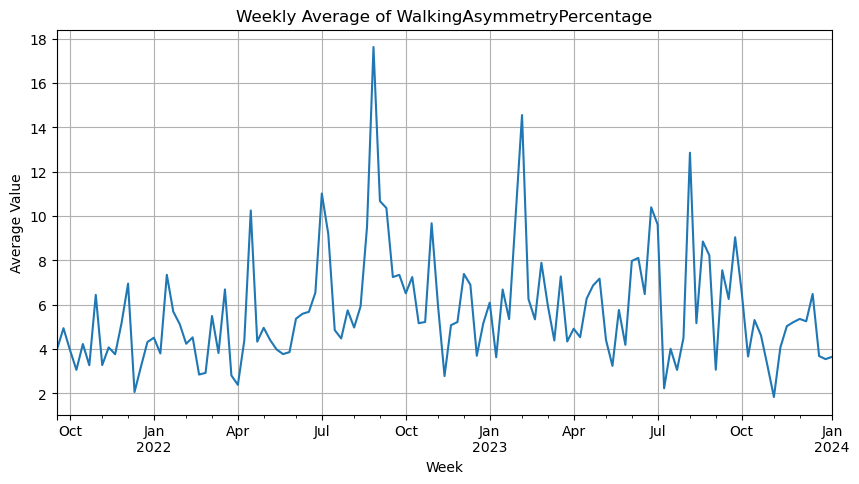

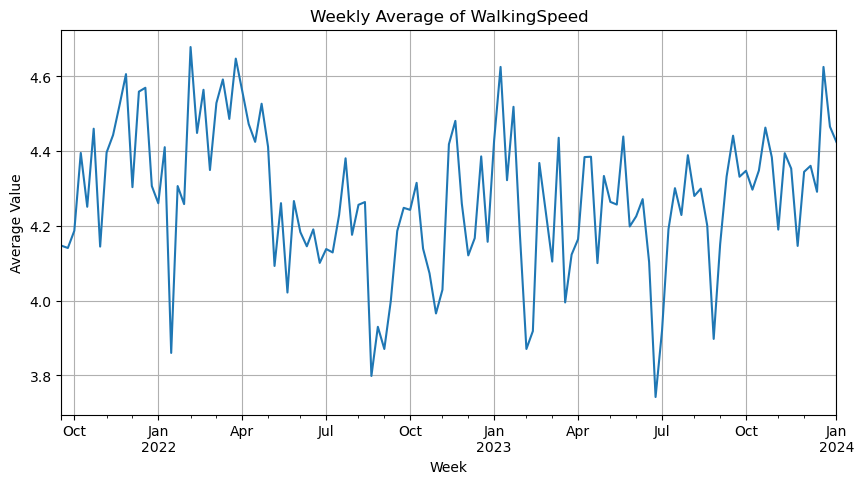

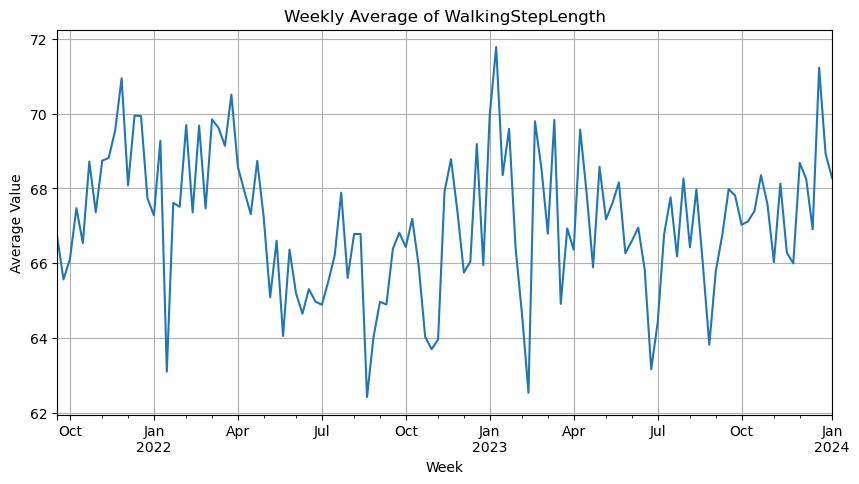

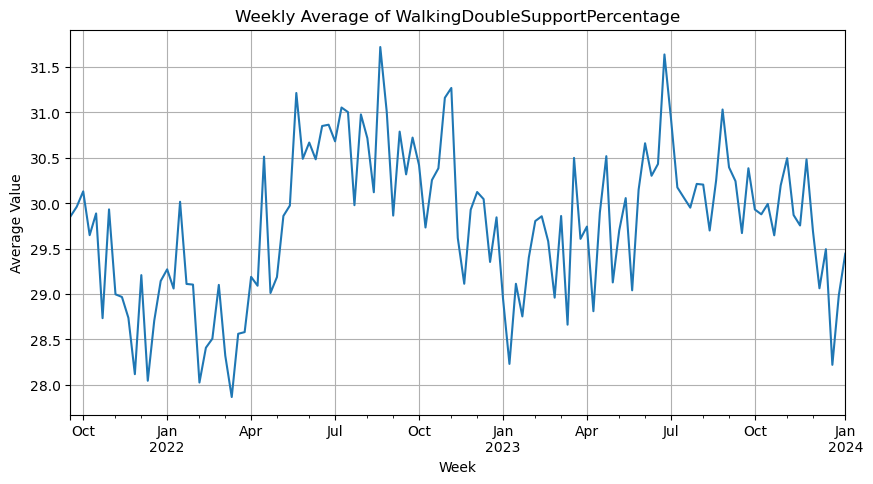

In [12]:

import pandas as pd
import matplotlib.pyplot as plt

dataset_files = [
"HeadphoneAudioExposure_processed_imputed.xlsx",
"StepCount_processed_imputed.xlsx",
"FlightsClimbed_processed_imputed.xlsx",
"WalkingAsymmetryPercentage_processed_imputed.xlsx",
"WalkingSpeed_processed_imputed.xlsx",
"WalkingStepLength_processed_imputed.xlsx",
"WalkingDoubleSupportPercentage_processed_imputed.xlsx"
]

for file_name in dataset_files:
    # Load the dataset
    df = pd.read_excel(f'{file_name}', parse_dates=['startDate'])
    # Ensure 'startDate' is a datetime type and set as index
    df['startDate'] = pd.to_datetime(df['startDate'])
    df.set_index('startDate', inplace=True)

    # Resample to get weekly averages and plot
    weekly_avg = df['value'].resample('W').mean()

    # Plotting
    plt.figure(figsize=(10, 5))
    weekly_avg.plot(title=f"Weekly Average of {file_name.replace('_processed_imputed.xlsx', '')}")
    plt.ylabel('Average Value')
    plt.xlabel('Week')
    plt.grid(True)
    plt.show()
    



Number 4---- In this code we can see the correlation between the datasets of my activities. So there is a positive strong correlation between the walking speed and walking step length. Also, there is a negative strong correleation between the walking double support percentage and walking step length value. And there is a negative strong correleation between the walking double support percentage and walking speed value. 

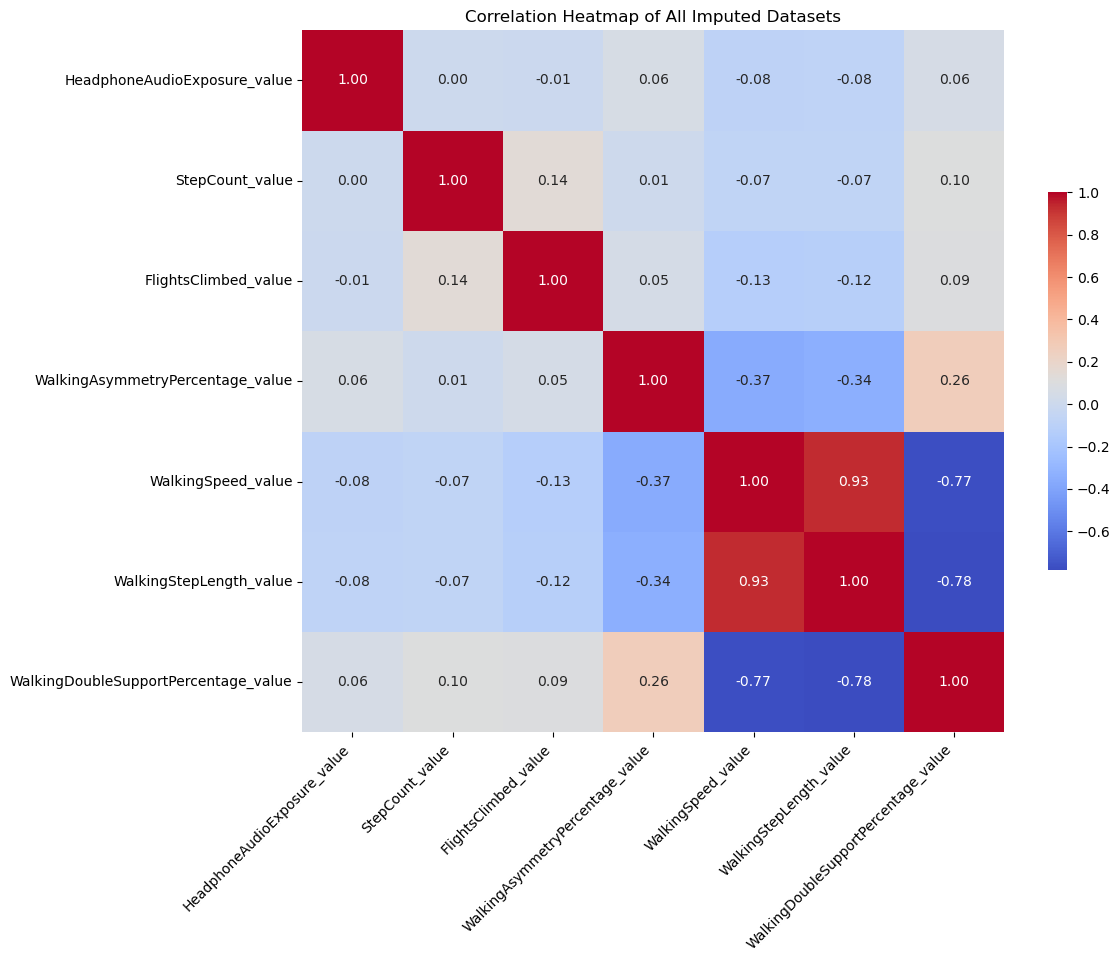

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the list of imputed dataset file names
dataset_files_imputed = [
    "HeadphoneAudioExposure_processed_imputed.xlsx",
    "StepCount_processed_imputed.xlsx",
    "FlightsClimbed_processed_imputed.xlsx",
    "WalkingAsymmetryPercentage_processed_imputed.xlsx",
    "WalkingSpeed_processed_imputed.xlsx",
    "WalkingStepLength_processed_imputed.xlsx",
    "WalkingDoubleSupportPercentage_processed_imputed.xlsx"
]

# Assuming all datasets have the same structure and can be merged
# Initialize an empty DataFrame to hold all numerical data
all_data = pd.DataFrame()

# Loop over each dataset, load numerical data, and combine into one DataFrame
for file_name in dataset_files_imputed:
    # Load the dataset
    df = pd.read_excel(file_name)
    
    # Select only numerical columns, excluding 'startDate' which is likely non-numeric
    numerical_df = df.select_dtypes(include=['float64', 'int64'])

    # Add a prefix to column names to avoid collisions when merging
    numerical_df = numerical_df.add_prefix(file_name.split('_')[0] + "_")
    
    # Merge numerical data from this file into the combined DataFrame
    if all_data.empty:
        all_data = numerical_df
    else:
        all_data = all_data.join(numerical_df, how='outer')

# Calculate the correlation matrix
corr_matrix = all_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap of All Imputed Datasets')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() # Adjusts plot to ensure everything fits without overlapping

plt.show()




Number 5 ----- This code plot my 3 dataset' trend analysis. To achieve the trend analysis of them I normalized the datasets so we can understand trend similarities between them. So, step counts and flight climbed are so similar to each other. As we observed from the correlation heatmap they are positively strongly correlated now we see their correlation from trend analysis. 

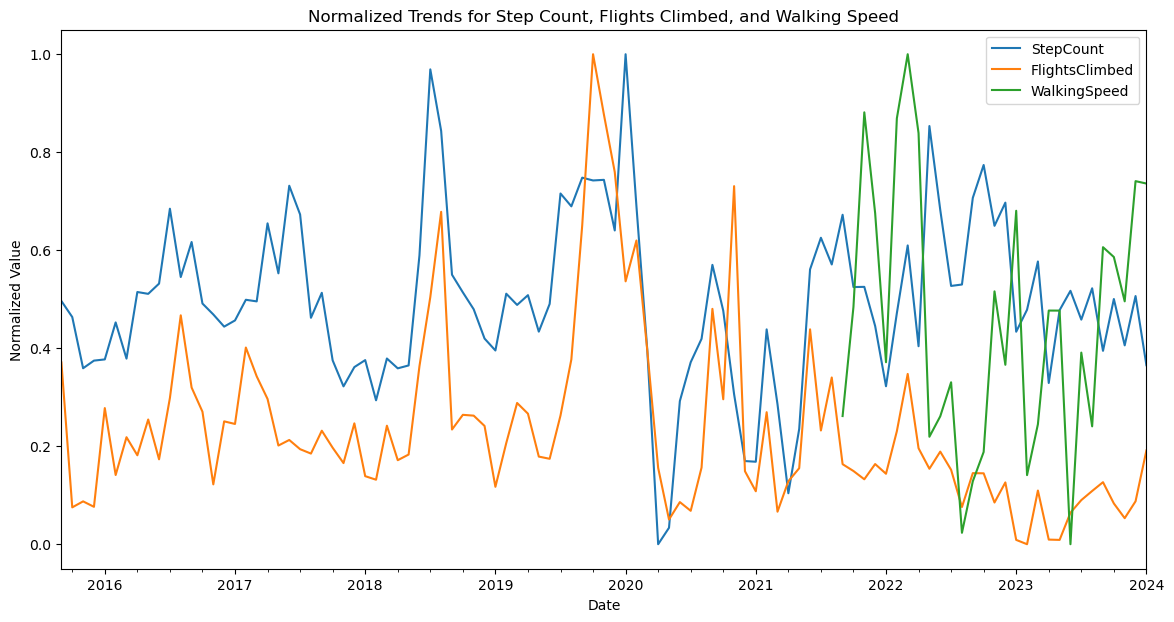

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load datasets
step_count_df = pd.read_excel('StepCount_processed_imputed.xlsx')
flights_climbed_df = pd.read_excel('FlightsClimbed_processed_imputed.xlsx')
walking_speed_df = pd.read_excel('WalkingSpeed_processed_imputed.xlsx')

# Convert dates to datetime and set as index
step_count_df['startDate'] = pd.to_datetime(step_count_df['startDate'])
flights_climbed_df['startDate'] = pd.to_datetime(flights_climbed_df['startDate'])
walking_speed_df['startDate'] = pd.to_datetime(walking_speed_df['startDate'])

step_count_df.set_index('startDate', inplace=True)
flights_climbed_df.set_index('startDate', inplace=True)
walking_speed_df.set_index('startDate', inplace=True)

# Resample and normalize data
scaler = MinMaxScaler()

step_count_resampled = step_count_df['value'].resample('M').mean().dropna().to_frame('value')
flights_climbed_resampled = flights_climbed_df['value'].resample('M').mean().dropna().to_frame('value')
walking_speed_resampled = walking_speed_df['value'].resample('M').mean().dropna().to_frame('value')

step_count_normalized = pd.Series(scaler.fit_transform(step_count_resampled)[:,0], index=step_count_resampled.index)
flights_climbed_normalized = pd.Series(scaler.fit_transform(flights_climbed_resampled)[:,0], index=flights_climbed_resampled.index)
walking_speed_normalized = pd.Series(scaler.fit_transform(walking_speed_resampled)[:,0], index=walking_speed_resampled.index)

# Combine into a single DataFrame
combined_df = pd.concat([step_count_normalized, flights_climbed_normalized, walking_speed_normalized], axis=1)
combined_df.columns = ['StepCount', 'FlightsClimbed', 'WalkingSpeed']

# Plot the normalized trends
combined_df.plot(figsize=(14, 7))
plt.title('Normalized Trends for Step Count, Flights Climbed, and Walking Speed')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.show()



Number 6 ---- This code breaks down my activity by days of the week to find out on which days I am  most active or inactive. Thus Fridays I am most active and sundays I am most inactive. Maybe I can prepare exercise plan for sundays to boost my average step count because I have time to do that and it's effect on my average daily step count or flight climbed data would be higher compare to other days. 

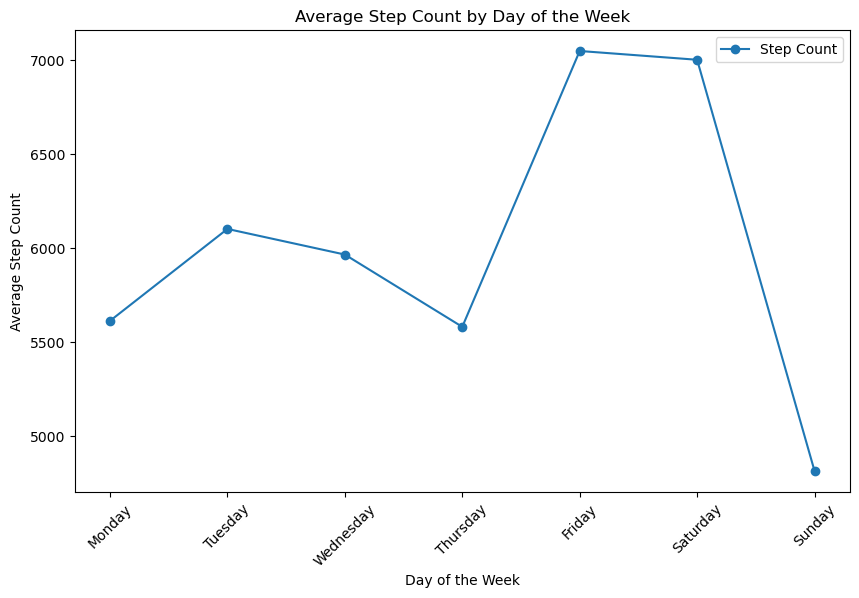

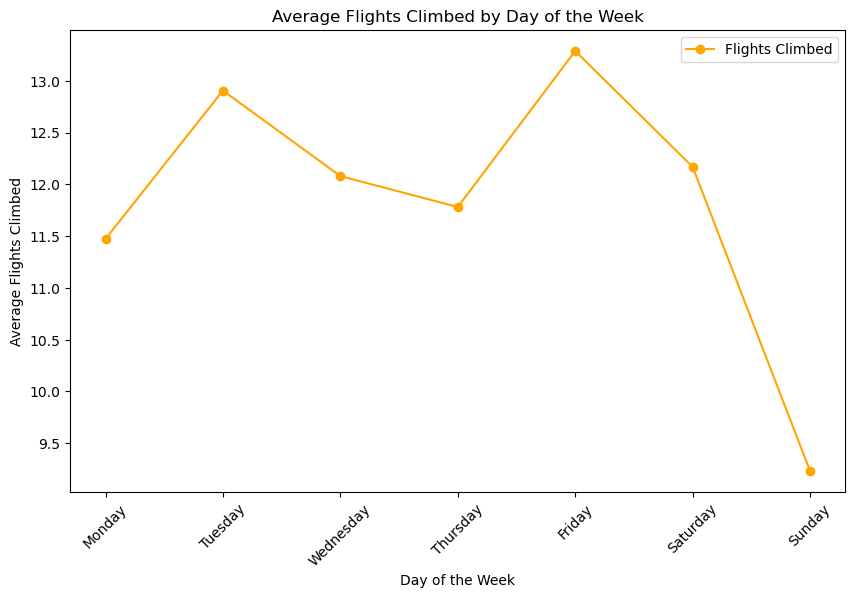

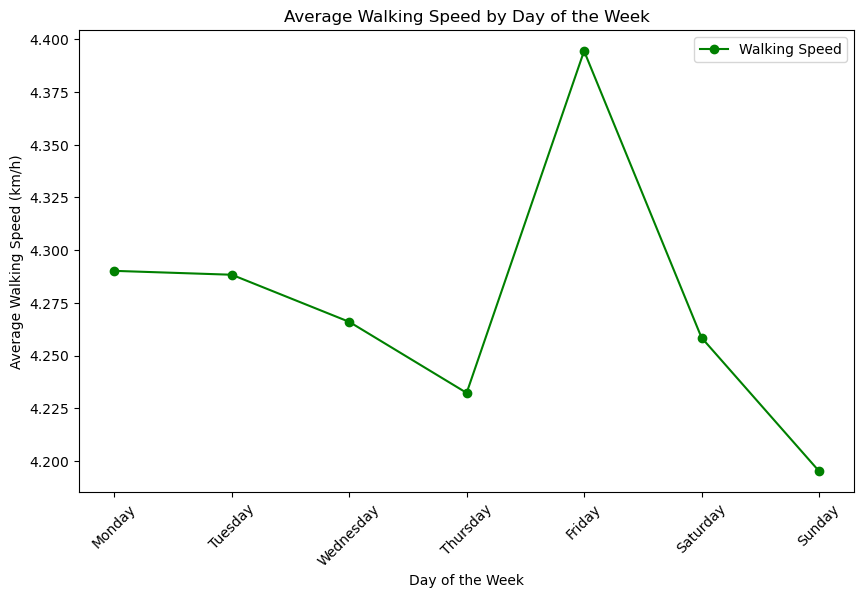

In [32]:
# Corrected code for generating separate plots for each activity type to address the scale issue.
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
step_count_df = pd.read_excel('StepCount_processed_imputed.xlsx')
flights_climbed_df = pd.read_excel('FlightsClimbed_processed_imputed.xlsx')
walking_speed_df = pd.read_excel('WalkingSpeed_processed_imputed.xlsx')

# Convert 'startDate' to datetime and extract the day of the week
step_count_df['startDate'] = pd.to_datetime(step_count_df['startDate'])
step_count_df['DayOfWeek'] = step_count_df['startDate'].dt.day_name()
flights_climbed_df['startDate'] = pd.to_datetime(flights_climbed_df['startDate'])
flights_climbed_df['DayOfWeek'] = flights_climbed_df['startDate'].dt.day_name()
walking_speed_df['startDate'] = pd.to_datetime(walking_speed_df['startDate'])
walking_speed_df['DayOfWeek'] = walking_speed_df['startDate'].dt.day_name()

# Group by day of the week and calculate the mean
step_count_avg = step_count_df.groupby('DayOfWeek')['value'].mean()
flights_climbed_avg = flights_climbed_df.groupby('DayOfWeek')['value'].mean()
walking_speed_avg = walking_speed_df.groupby('DayOfWeek')['value'].mean()

# Sort the index by day of the week for proper plotting
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
step_count_avg = step_count_avg.reindex(ordered_days)
flights_climbed_avg = flights_climbed_avg.reindex(ordered_days)
walking_speed_avg = walking_speed_avg.reindex(ordered_days)

# Plot for Step Count
plt.figure(figsize=(10, 6))
plt.plot(step_count_avg.index, step_count_avg.values, marker='o', label='Step Count')
plt.title('Average Step Count by Day of the Week')
plt.ylabel('Average Step Count')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plot for Flights Climbed
plt.figure(figsize=(10, 6))
plt.plot(flights_climbed_avg.index, flights_climbed_avg.values, marker='o', color='orange', label='Flights Climbed')
plt.title('Average Flights Climbed by Day of the Week')
plt.ylabel('Average Flights Climbed')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plot for Walking Speed
plt.figure(figsize=(10, 6))
plt.plot(walking_speed_avg.index, walking_speed_avg.values, marker='o', color='green', label='Walking Speed')
plt.title('Average Walking Speed by Day of the Week')
plt.ylabel('Average Walking Speed (km/h)')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.legend()
plt.show()


Number 7 ---- I have hyphothesis that I am walking faster at the winter seasons than summer seasons because generally in the cold weathers I walk faster to less freeze. So, I compare the averge walking speed of summer season and winter season. Accoridng to the avergaes I am walking slightly faster in the winter seasons than the summer seasons as we can see from the output. Also in the second code we can see the years 2022 2023 in the bar chart so both graph's walking speed value decreases from winter to summer season. 

In [16]:
import pandas as pd

# Load the walking speed data
file_path = 'WalkingSpeed_processed_imputed.xlsx'
df = pd.read_excel(file_path)

# Ensure the 'startDate' is a datetime
df['startDate'] = pd.to_datetime(df['startDate'])

# Extract month for seasonality analysis
df['month'] = df['startDate'].dt.month

# Define winter and summer months (assuming Northern Hemisphere)
# Winter: December, January, February (12, 1, 2)
# Summer: June, July, August (6, 7, 8)
winter_months = [12, 1, 2]
summer_months = [6, 7, 8]

# Filter data for winter and summer
winter_data = df[df['month'].isin(winter_months)]
summer_data = df[df['month'].isin(summer_months)]

# Calculate average walking speeds for each season
average_winter_speed = winter_data['value'].mean()
average_summer_speed = summer_data['value'].mean()

# Output the results
print(f"Average Winter Walking Speed: {average_winter_speed} km/hr")
print(f"Average Summer Walking Speed: {average_summer_speed} km/hr")


Average Winter Walking Speed: 4.329003708298819 km/hr
Average Summer Walking Speed: 4.147496158578425 km/hr


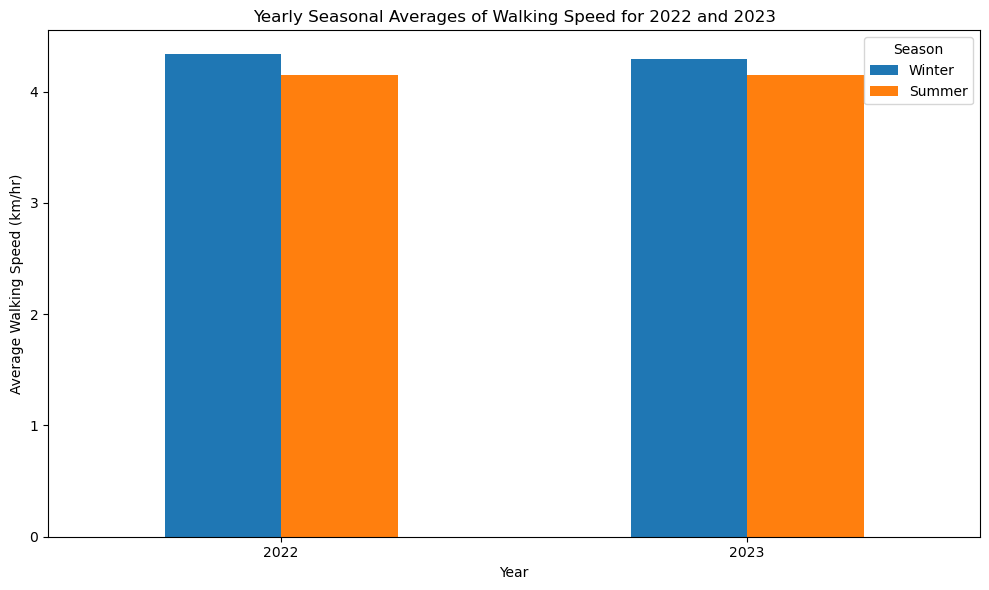

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the walking speed data
file_path = 'WalkingSpeed_processed_imputed.xlsx'  # Adjust the path if needed
df = pd.read_excel(file_path)

# Ensure the 'startDate' is a datetime
df['startDate'] = pd.to_datetime(df['startDate'])

# Extract year and month for seasonality analysis
df['year'] = df['startDate'].dt.year
df['month'] = df['startDate'].dt.month

# Define winter and summer months (assuming Northern Hemisphere)
winter_months = [12, 1, 2]  # December, January, February
summer_months = [6, 7, 8]   # June, July, August

# Initialize a dictionary to hold average speeds for each season and year
seasonal_averages = {'Winter': {}, 'Summer': {}}

# Calculate average walking speeds for each season by year for 2022 and 2023
for year in [2022, 2023]:
    # Filter for the specific year
    year_data = df[df['year'] == year]
    
    # Winter data for the year (including December of the previous year)
    if year > df['year'].min():
        winter_data = pd.concat([
            df[(df['month'] == 12) & (df['year'] == year - 1)],
            year_data[year_data['month'].isin(winter_months)]
        ])
    else:
        winter_data = year_data[year_data['month'].isin(winter_months)]
        
    # Summer data for the year
    summer_data = year_data[year_data['month'].isin(summer_months)]
    
    # Calculate average walking speeds for winter and summer
    seasonal_averages['Winter'][year] = winter_data['value'].mean()
    seasonal_averages['Summer'][year] = summer_data['value'].mean()

# Convert the seasonal averages dictionary to a DataFrame
seasonal_df = pd.DataFrame(seasonal_averages)

# Filter the DataFrame for the years 2022 and 2023
seasonal_df_filtered = seasonal_df.loc[[2022, 2023]]

# Plot a bar chart of the seasonal averages for 2022 and 2023
seasonal_df_filtered.plot(kind='bar', figsize=(10, 6))
plt.title('Yearly Seasonal Averages of Walking Speed for 2022 and 2023')
plt.xlabel('Year')
plt.ylabel('Average Walking Speed (km/hr)')
plt.xticks(rotation=0)
plt.legend(title='Season')
plt.tight_layout()

plt.savefig('seasonal_averages_2022_2023.png')

plt.show()




Number 7---- I wonder that commuting with my personal car affected my walking step count daily after I purchased my car at the beginning of October 2022. I wonder this because there is a general belief that if you have a car you walk less. To learn this effect on my walking step count I splited my data into before October 2022 and after October 2022. So, my daily average step count before purchasing the car is 5985 and after purchasing is 6202. Bu this approach did not satisfy me because my step count data start from 2015 therefore my lifestyle has changed many times which affects my walking routine also, I have changed my phone at 2021 september maybe there could be difference of sensistiveness between the devices. So I analyse the data 2021 October - 2022 October (I purchased my car) and present. So, in these two periods my life style is very similar. So, in the second code I calculated the average daily steps of mine. My daily average step count of the period when I did not have car is more than the I owned a car. Their values are (6604.449315068493, 6202.874186550976) respectively. Therefore general belief is true for my lifestyle

In [17]:
import pandas as pd

# Load your walking dataset
file_path = 'StepCount_processed_imputed.xlsx'  # Replace with your actual file path
df = pd.read_excel(file_path)

# Ensure the 'startDate' is a datetime
df['startDate'] = pd.to_datetime(df['startDate'])

# Define the car purchase date
car_purchase_date = pd.to_datetime('2022-10-01')

# Split the data into before and after the car purchase
before_car = df[df['startDate'] < car_purchase_date]
after_car = df[df['startDate'] >= car_purchase_date]

# Calculate average walking activity (e.g., steps or distance) for each period
average_before_car = before_car['value'].mean()
average_after_car = after_car['value'].mean()

# Output the results
print(f"Average Walking Activity Before Car Purchase: {average_before_car}")
print(f"Average Walking Activity After Car Purchase: {average_after_car}")

# Compare the averages
if average_before_car > average_after_car:
    print("You walked more before purchasing the car.")
elif average_before_car < average_after_car:
    print("You walked more after purchasing the car.")
else:
    print("Walking activity remained about the same.")


Average Walking Activity Before Car Purchase: 5985.083222778388
Average Walking Activity After Car Purchase: 6202.874186550976
You walked more after purchasing the car.


Number 8--- 

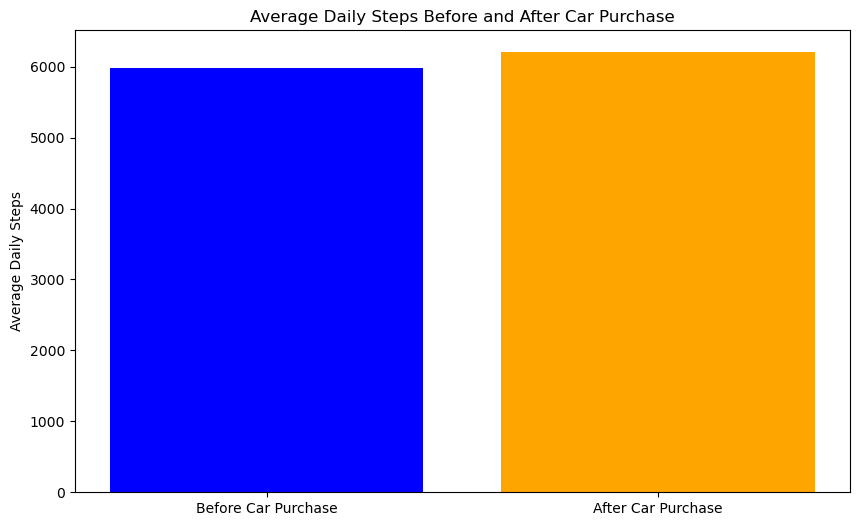

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your walking dataset
file_path = 'StepCount_processed_imputed.xlsx'  # Replace with your actual file path
df = pd.read_excel(file_path)

# Ensure the 'startDate' is a datetime
df['startDate'] = pd.to_datetime(df['startDate'])

# Define the car purchase date
car_purchase_date = pd.to_datetime('2022-10-01')

# Split the data into before and after the car purchase
before_car = df[df['startDate'] < car_purchase_date]
after_car = df[df['startDate'] >= car_purchase_date]

# Calculate average walking activity (e.g., steps or distance) for each period
average_before_car = before_car['value'].mean()
average_after_car = after_car['value'].mean()

# For visualization, we will use a bar chart since we are comparing two distinct categories
averages = [average_before_car, average_after_car]
periods = ['Before Car Purchase', 'After Car Purchase']

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(periods, averages, color=['blue', 'orange'])
plt.title('Average Daily Steps Before and After Car Purchase')
plt.ylabel('Average Daily Steps')
plt.show()


Number 9 ------ I have been wondering that my headphone types whether affect my headphone audio exposure or not. So I compare the headphone audio exposure levels of my two headphone which are Sony WH-1000XM-5 and Apple Airpods. Therefore, I compared the daily average db of them. As we can see from the output Apple Airpods daily db is more than the Sony WH-1000XM-5. I think the reason behind this result is the quality difference between two headphones. I mostly listen my musics with airpods at high volume than WH-1000XM5. 

In [20]:
import pandas as pd

# Load the headphone exposure dataset
file_path = 'HeadphoneAudioExposure_processed_imputed.xlsx'
df = pd.read_excel(file_path)

# Define a function to parse the headphone name from the device information
def parse_headphone_name(device_info):
    if 'WH-1000XM5' in device_info:
        return 'WH-1000XM5'
    elif 'AirPods' in device_info:
        return 'AirPods'
    else:
        return 'Other'

# Apply the function to the 'device' column to create a new 'headphone_name' column
df['headphone_name'] = df['device'].apply(parse_headphone_name)

# Filter the dataset into two groups based on the headphone names
df_wh1000xm5 = df[df['headphone_name'] == 'WH-1000XM5']
df_airpods = df[df['headphone_name'] == 'AirPods']

# Calculate the average dB exposure for each headphone
avg_db_exposure_wh1000xm5 = df_wh1000xm5['value'].mean()
avg_db_exposure_airpods = df_airpods['value'].mean()

# Output the results
print(f"Average dB Exposure for WH-1000XM5: {avg_db_exposure_wh1000xm5}")
print(f"Average dB Exposure for AirPods: {avg_db_exposure_airpods}")
(avg_db_exposure_wh1000xm5, avg_db_exposure_airpods)

Average dB Exposure for WH-1000XM5: 74.09418307898345
Average dB Exposure for AirPods: 75.92846764028802


(74.09418307898345, 75.92846764028802)

Number 10--- I wondered that the days I am exposed in high db from my headphones I would walk more on these days. 
This code shows correlation between thhe step count and headphone audio exposure. So we can understand the db and step count relationship is meaningless for me because correlation with them is so low. 

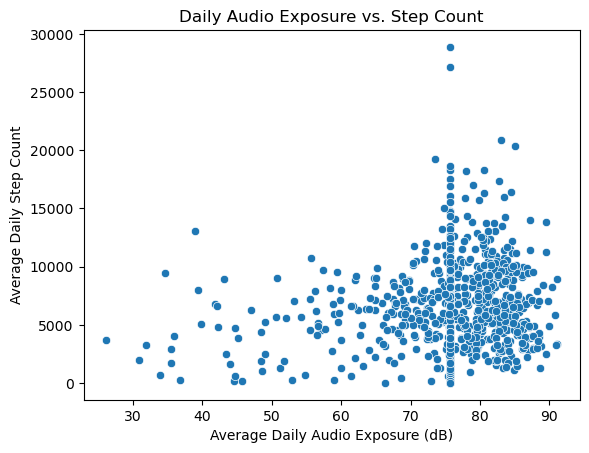

The correlation between daily audio exposure and step count is: 0.1546918287443016


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets for headphone audio exposure and step count
audio_exposure_path = 'HeadphoneAudioExposure_processed_imputed.xlsx'
step_count_path = 'StepCount_processed_imputed.xlsx'

audio_exposure_df = pd.read_excel(audio_exposure_path)
step_count_df = pd.read_excel(step_count_path)

# Ensure the 'startDate' column is a datetime and create a common index for both dataframes
audio_exposure_df['startDate'] = pd.to_datetime(audio_exposure_df['startDate'])
step_count_df['startDate'] = pd.to_datetime(step_count_df['startDate'])

audio_exposure_df.set_index('startDate', inplace=True)
step_count_df.set_index('startDate', inplace=True)

# Resample to a common time frame (e.g., daily) and normalize if necessary
daily_audio_exposure = audio_exposure_df['value'].resample('D').mean()
daily_step_count = step_count_df['value'].resample('D').mean()

# Merge the datasets on the index (startDate) after resampling
combined_df = pd.merge(daily_audio_exposure, daily_step_count, left_index=True, right_index=True, suffixes=('_audio', '_steps'))

# Drop any NaN values that may have been introduced by resampling
combined_df.dropna(inplace=True)

# Plot a scatterplot to visualize the relationship between audio exposure and step count
sns.scatterplot(data=combined_df, x='value_audio', y='value_steps')
plt.title('Daily Audio Exposure vs. Step Count')
plt.xlabel('Average Daily Audio Exposure (dB)')
plt.ylabel('Average Daily Step Count')
plt.show()

# Calculate the correlation coefficient to quantify the relationship
correlation = combined_df['value_audio'].corr(combined_df['value_steps'])
print(f"The correlation between daily audio exposure and step count is: {correlation}")

# Please note: replace the file paths
